n_points=839680, n_snapshots=18
ISO: T=4.0
Train snapshots: 12 (predict 6 steps)


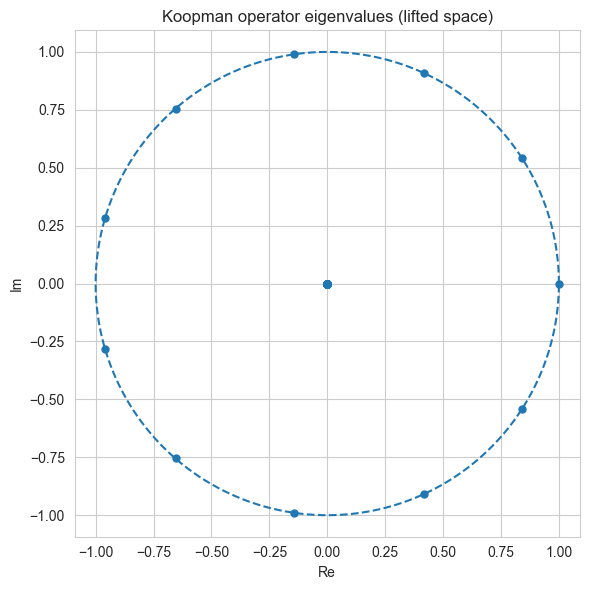

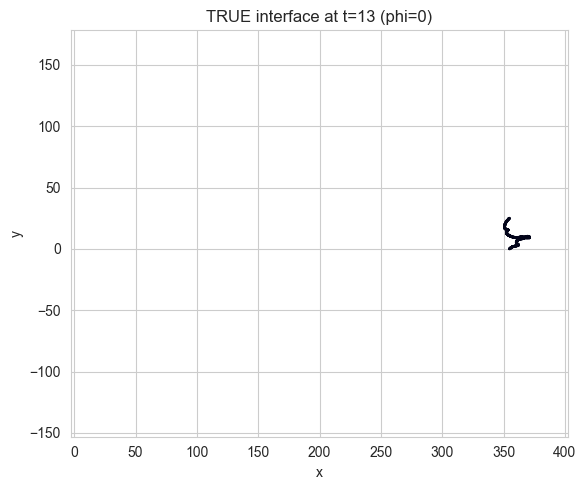

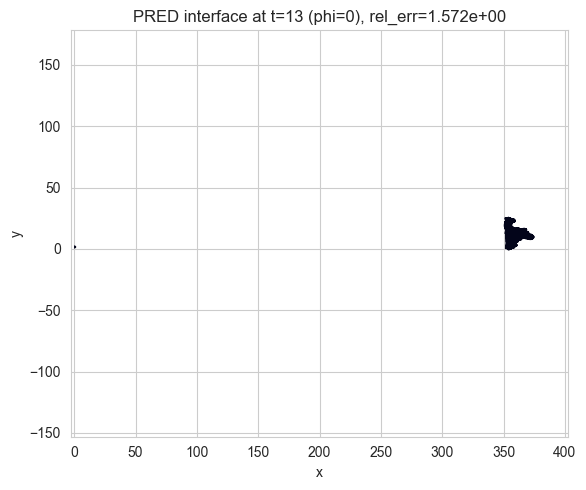

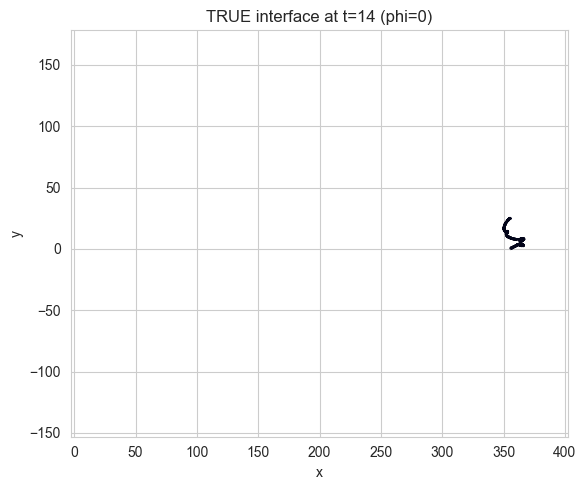

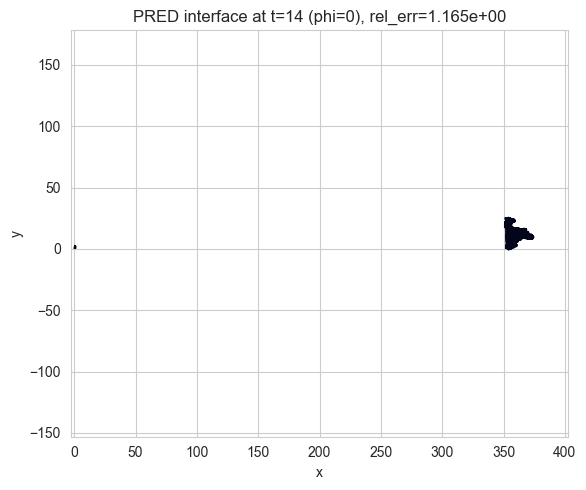

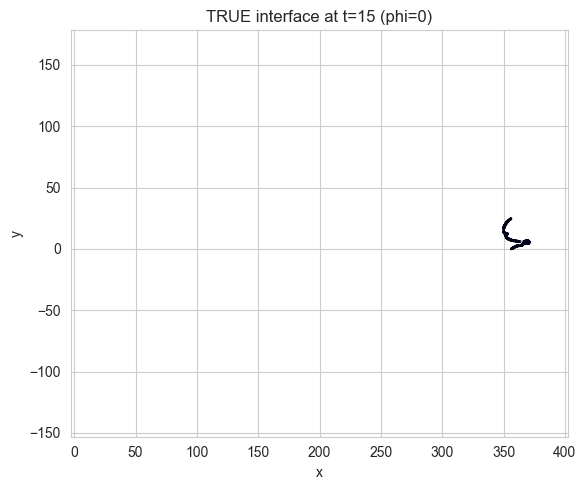

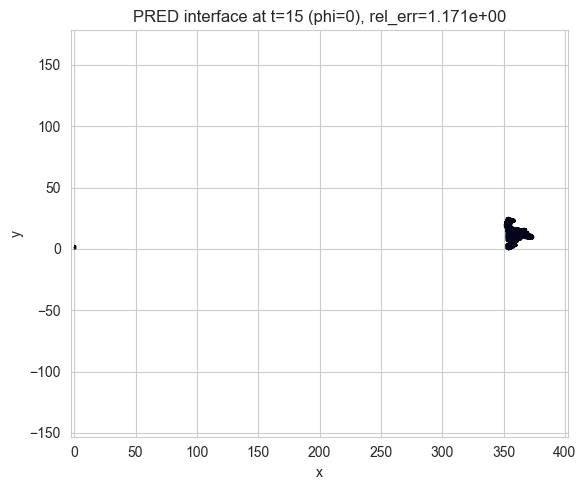

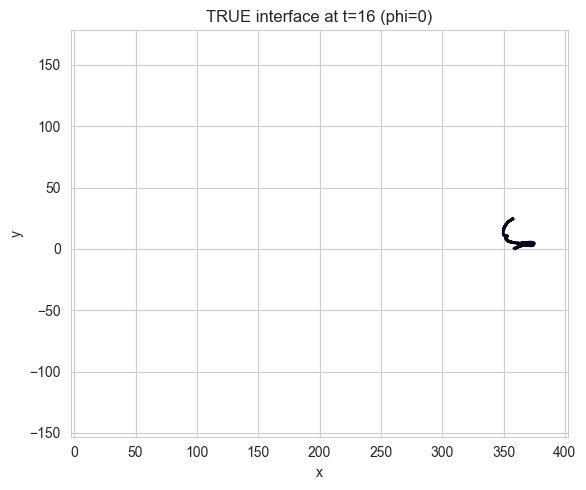

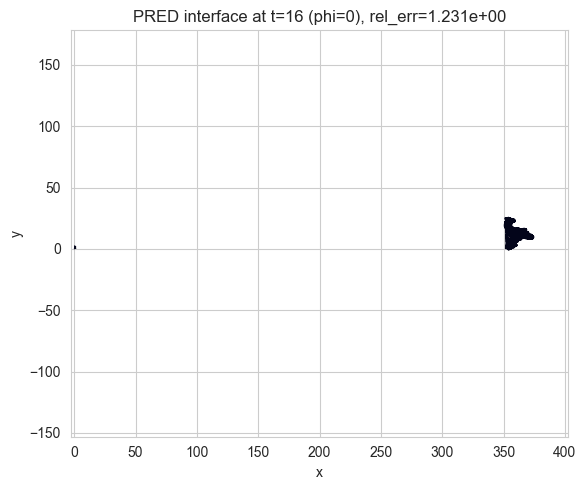

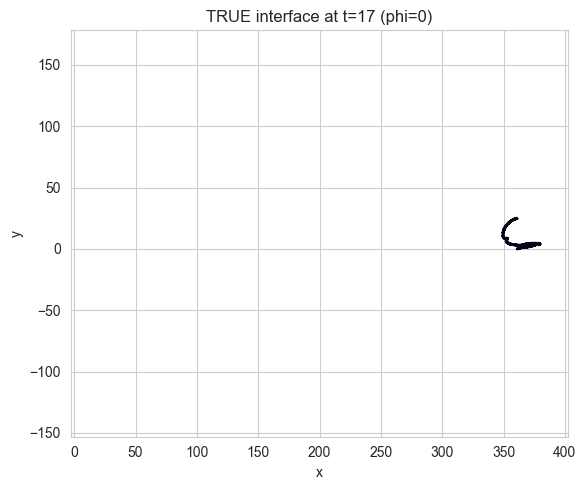

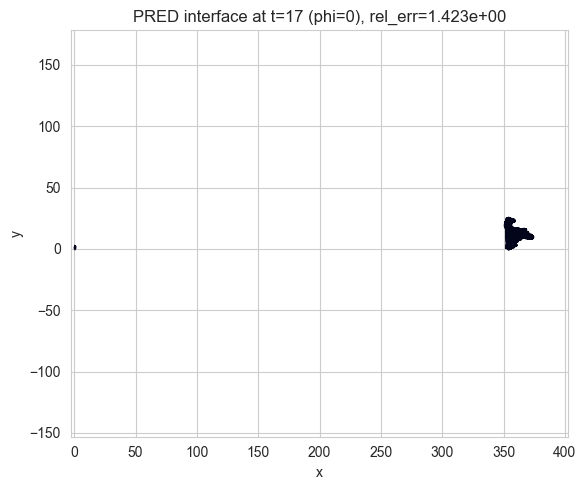

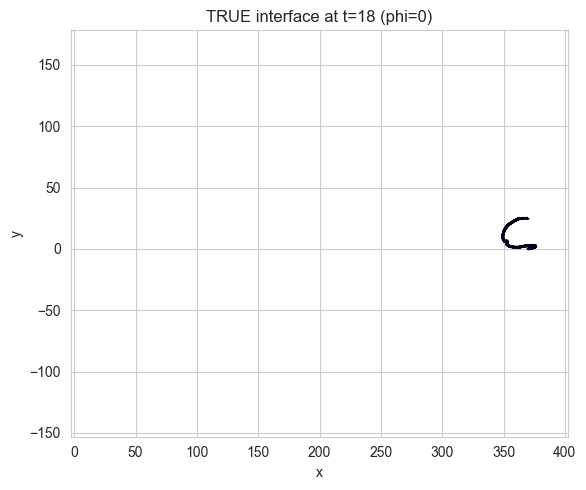

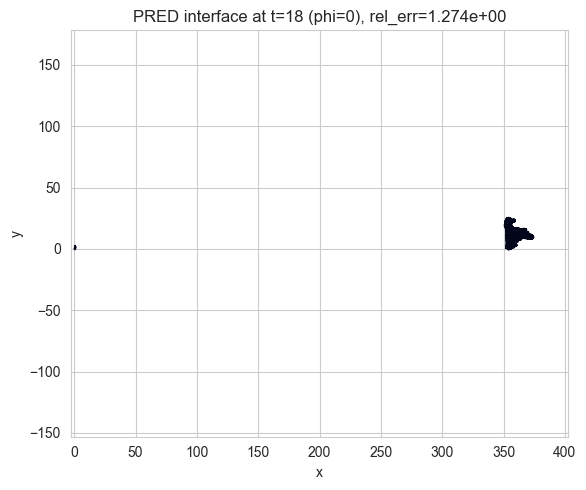

In [1]:
from __future__ import annotations

from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# Optional (cluster)
from mpi4py import MPI


# ============================================================
# INPUT PARAMETERS (match your I/O template)
# ============================================================

TIME_STEP_START = 1
TIME_STEP_END   = 18

PHI      = 0.40
LAT_SIZE = "025"
POST     = True

BASE_DIR = Path("../data/isocontours")

# Isotherm definition (must exist as a full-field column)
ISO_FIELD = "T"
ISO_LEVEL = 4.0

SORT_COLS = ["x", "y"]
COORD_TOL = 0.0

# Time step size (physical), used only for reporting / plotting
DT = 1.0

# Narrow-band weighting around interface (recommended)
USE_BAND_WEIGHT = True
BAND_WIDTH = 2.0e-3   # tune to your mesh scale
BAND_FLOOR = 0.0      # 0 = strict near-front emphasis

# POD / Koopman settings
R_POD = 50            # reduced dimension r (choose 20–200 typically)
USE_POLY_LIFT = True  # EDMD in reduced space
POLY_DEGREE = 2       # 2 is usually enough; 3 can get big

# Train / test split in time
N_TRAIN = 12          # first N_TRAIN snapshots used to fit Koopman
PRED_STEPS = 6        # number of steps to predict beyond training

# Plotting
PLOT_TRUE_VS_PRED = True
PLOT_EIGS = True


# ============================================================
# PATH + READ HELPERS
# ============================================================

def field_csv_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, needed_cols: list[str], sort_cols: list[str]) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")

    df = pd.read_csv(path)

    missing = [c for c in (sort_cols + needed_cols) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + needed_cols)
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)
    return df


# ============================================================
# SIGNED DISTANCE TO ISOTHERM ON UNSTRUCTURED 2D POINTS
#   - extract isocontour vertices with tricontour
#   - approximate distance via nearest contour vertex
#   - sign from (T - T_iso)
# ============================================================

def _make_kdtree(points_xy: np.ndarray):
    """Return nn_dist(query_xy)->distances with SciPy if available, else sklearn."""
    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(points_xy)
        def nn_dist(q):
            d, _ = tree.query(q, k=1)
            return d
        return nn_dist
    except Exception:
        from sklearn.neighbors import KDTree
        tree = KDTree(points_xy)
        def nn_dist(q):
            d, _ = tree.query(q, k=1)
            return d[:, 0]
        return nn_dist


def extract_isocontour_vertices(tri: mtri.Triangulation, values: np.ndarray, level: float) -> np.ndarray:
    """
    Robust across matplotlib versions by using cs.allsegs (fallbacks included).
    Returns (M,2) vertices for the contour at 'level'.
    """
    fig = plt.figure(figsize=(1, 1))
    ax = fig.add_subplot(111)

    try:
        cs = ax.tricontour(tri, values, levels=[level])
    except Exception:
        plt.close(fig)
        return np.empty((0, 2), dtype=np.float64)

    verts_all = []

    if hasattr(cs, "allsegs") and cs.allsegs and len(cs.allsegs[0]) > 0:
        for seg in cs.allsegs[0]:
            if seg is not None and len(seg) > 0:
                verts_all.append(np.asarray(seg, dtype=np.float64))

    elif hasattr(cs, "get_paths"):
        for p in cs.get_paths():
            v = getattr(p, "vertices", None)
            if v is not None and len(v) > 0:
                verts_all.append(np.asarray(v, dtype=np.float64))

    elif hasattr(cs, "collections") and len(cs.collections) > 0:
        for p in cs.collections[0].get_paths():
            v = getattr(p, "vertices", None)
            if v is not None and len(v) > 0:
                verts_all.append(np.asarray(v, dtype=np.float64))

    plt.close(fig)

    if not verts_all:
        return np.empty((0, 2), dtype=np.float64)

    return np.vstack(verts_all)


def signed_distance_to_isotherm(coords_xy: np.ndarray, iso_field: np.ndarray,
                                tri: mtri.Triangulation, level: float) -> np.ndarray:
    contour_xy = extract_isocontour_vertices(tri, iso_field, level)
    if contour_xy.shape[0] == 0:
        raise RuntimeError(
            "Could not extract isocontour (no vertices). "
            "Check ISO_FIELD/ISO_LEVEL and that the level lies within the field range at this timestep."
        )

    nn_dist = _make_kdtree(contour_xy)
    dist = nn_dist(coords_xy)

    s = np.sign(iso_field - level)
    s[s == 0.0] = 1.0
    return s * dist


def band_weight(phi: np.ndarray, width: float, floor: float = 0.0) -> np.ndarray:
    """w = floor + (1-floor)*exp(-(phi/width)^2)"""
    if width <= 0:
        return np.ones_like(phi)
    w = np.exp(-(phi / width) ** 2)
    return floor + (1.0 - floor) * w


# ============================================================
# POD + (ED)MD / KOOPMAN LEARNING
# ============================================================

def pod_basis(X: np.ndarray, r: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    X: (n_state, n_snap)
    Returns U_r, s, mean
      - mean: (n_state,1) mean snapshot
      - U_r: (n_state,r)
    """
    mean = X.mean(axis=1, keepdims=True)
    Xc = X - mean
    U, s, Vt = np.linalg.svd(Xc, full_matrices=False)
    r = min(r, U.shape[1])
    return U[:, :r], s, mean


def lift_poly(Z: np.ndarray, degree: int) -> np.ndarray:
    """
    Polynomial lifting on reduced coords.
    Z: (r, n_snap)
    Returns Psi(Z): (n_feat, n_snap)
    Includes bias + linear + higher-order terms (sklearn PolynomialFeatures).
    """
    from sklearn.preprocessing import PolynomialFeatures
    pf = PolynomialFeatures(degree=degree, include_bias=True)
    Psi = pf.fit_transform(Z.T).T  # (n_feat, n_snap)
    return Psi, pf


def fit_koopman(Psi: np.ndarray) -> np.ndarray:
    """
    Fit K in Psi-space:
      Psi_{k+1} ≈ K Psi_k
    Psi: (n_feat, n_snap)
    Returns K: (n_feat, n_feat)
    """
    Psi_X = Psi[:, :-1]
    Psi_Y = Psi[:, 1:]
    K = Psi_Y @ np.linalg.pinv(Psi_X)
    return K


def predict_koopman(K: np.ndarray, psi0: np.ndarray, n_steps: int) -> np.ndarray:
    """
    Iterative prediction in Psi-space.
    psi0: (n_feat,)
    Returns Psi_pred: (n_feat, n_steps+1) including initial.
    """
    Psi_pred = np.zeros((K.shape[0], n_steps + 1), dtype=np.float64)
    Psi_pred[:, 0] = psi0
    for k in range(n_steps):
        Psi_pred[:, k + 1] = K @ Psi_pred[:, k]
    return Psi_pred


def plot_interface(tri: mtri.Triangulation, phi: np.ndarray, title: str):
    """Plot the zero level-set (interface) on triangulation."""
    plt.figure(figsize=(6, 5))
    # draw a few distance contours for context
    plt.tricontour(tri, phi, levels=15, linewidths=0.4)
    # interface (phi=0)
    plt.tricontour(tri, phi, levels=[0.0], linewidths=2.0)
    plt.title(title)
    plt.xlabel("x"); plt.ylabel("y")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


# ============================================================
# MAIN: build phi snapshots, learn Koopman, predict interface
# ============================================================

comm = MPI.COMM_WORLD
rank = comm.rank

times = list(range(TIME_STEP_START, TIME_STEP_END + 1))
needed_cols = [ISO_FIELD]

# Read reference timestep
ref_path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
df0 = read_field_sorted(ref_path, needed_cols, SORT_COLS)
coords_ref = df0[SORT_COLS].to_numpy(dtype=np.float64)
iso0 = df0[ISO_FIELD].to_numpy(dtype=np.float64)

tri = mtri.Triangulation(coords_ref[:, 0], coords_ref[:, 1])

n_points = coords_ref.shape[0]
n_snapshots = len(times)

if rank == 0:
    print(f"n_points={n_points}, n_snapshots={n_snapshots}")
    print(f"ISO: {ISO_FIELD}={ISO_LEVEL}")
    print(f"Train snapshots: {N_TRAIN} (predict {PRED_STEPS} steps)")

# Build signed-distance snapshots (phi)
snapshots_phi = []

for i, t in enumerate(times):
    path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    dft = read_field_sorted(path, needed_cols, SORT_COLS)

    coords_t = dft[SORT_COLS].to_numpy(dtype=np.float64)
    iso_t = dft[ISO_FIELD].to_numpy(dtype=np.float64)

    if coords_t.shape[0] != n_points:
        raise ValueError(f"Inconsistent n_points at t={t}: {coords_t.shape[0]} vs {n_points}")

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t, coords_ref)
    else:
        same = np.allclose(coords_t, coords_ref, atol=COORD_TOL, rtol=0.0)

    if not same:
        raise ValueError(
            f"Coordinates mismatch at timestep {t}. "
            f"Set COORD_TOL>0 or interpolate onto a common grid."
        )

    phi_t = signed_distance_to_isotherm(coords_t, iso_t, tri, ISO_LEVEL)

    if USE_BAND_WEIGHT:
        phi_t = phi_t * band_weight(phi_t, BAND_WIDTH, BAND_FLOOR)

    snapshots_phi.append(phi_t)

# X_phi: (n_state, n_snap)
X_phi = np.stack(snapshots_phi, axis=1)

# Split train/test in time
if N_TRAIN < 2 or N_TRAIN > n_snapshots:
    raise ValueError("N_TRAIN must be in [2, n_snapshots].")

X_train = X_phi[:, :N_TRAIN]
X_test  = X_phi[:, N_TRAIN:]  # optional

# POD reduction
U_r, svals, mean_phi = pod_basis(X_train, R_POD)
Z_train = U_r.T @ (X_train - mean_phi)  # (r, N_TRAIN)

# Build lifted coordinates for Koopman
if USE_POLY_LIFT:
    Psi_train, poly = lift_poly(Z_train, POLY_DEGREE)
else:
    Psi_train = np.vstack([np.ones((1, Z_train.shape[1])), Z_train])  # bias + linear

# Fit Koopman operator in lifted space
K = fit_koopman(Psi_train)

if rank == 0 and PLOT_EIGS:
    eigs = np.linalg.eigvals(K)
    plt.figure(figsize=(6, 6))
    plt.scatter(eigs.real, eigs.imag, s=25)
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), linestyle="--")
    plt.title("Koopman operator eigenvalues (lifted space)")
    plt.xlabel("Re"); plt.ylabel("Im")
    plt.axis("equal"); plt.grid(True); plt.tight_layout()
    plt.show()

# Predict forward from last TRAIN state
psi0 = Psi_train[:, -1]
Psi_pred = predict_koopman(K, psi0, PRED_STEPS)  # includes initial

# Map prediction back to reduced Z (only if using polynomial lift)
if USE_POLY_LIFT:
    # PolynomialFeatures ordering: [1, z1, z2, ..., z_r, z1^2, z1 z2, ...]
    # The linear terms start at index 1 and run for r entries.
    r = Z_train.shape[0]
    Z_pred = Psi_pred[1:1+r, :]  # (r, PRED_STEPS+1)
else:
    Z_pred = Psi_pred[1:, :]     # bias removed

# Reconstruct phi prediction in full space
X_pred = (U_r @ Z_pred) + mean_phi  # (n_state, PRED_STEPS+1)

# Compare against truth if available
if rank == 0 and PLOT_TRUE_VS_PRED:
    # Prediction corresponds to timesteps:
    # last train index is times[N_TRAIN-1] = t_train_last
    # predicted k=1 corresponds to next timestep t_train_last+1, etc.
    t_train_last = times[N_TRAIN - 1]

    for k in range(1, PRED_STEPS + 1):
        t_pred = t_train_last + k
        if t_pred not in times:
            # no ground truth available in loaded window
            plot_interface(tri, X_pred[:, k], f"PRED interface at t={t_pred} (phi=0)")
            continue

        idx_true = times.index(t_pred)
        phi_true = X_phi[:, idx_true]
        phi_hat  = X_pred[:, k]

        # relative L2 error (optionally focus on band by re-weighting)
        if USE_BAND_WEIGHT:
            w = band_weight(phi_true, BAND_WIDTH, BAND_FLOOR)
            num = np.linalg.norm((phi_hat - phi_true) * w)
            den = np.linalg.norm(phi_true * w) + 1e-14
        else:
            num = np.linalg.norm(phi_hat - phi_true)
            den = np.linalg.norm(phi_true) + 1e-14
        rel_err = num / den

        plot_interface(tri, phi_true, f"TRUE interface at t={t_pred} (phi=0)")
        plot_interface(tri, phi_hat,  f"PRED interface at t={t_pred} (phi=0), rel_err={rel_err:.3e}")


In [ ]:
from __future__ import annotations

from flamekit.io_fields import field_path
from flamekit.io_fronts import Case
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optional (cluster)
from mpi4py import MPI


# ============================================================
# USER SETTINGS (I/O matches your template)
# ============================================================

TIME_STEP_START = 1
TIME_STEP_END   = 19

PHI      = 0.40
LAT_SIZE = "025"
POST     = True

BASE_DIR = Path("../data/isocontours")

# Isotherm definition
ISO_FIELD = "T"
ISO_LEVEL = 4.5

SORT_COLS = ["x", "y"]
COORD_TOL = 0.0

# FNO needs a uniform grid:
NX = 128
NY = 128

# Model learns signed-distance dynamics (phi field)
# Optionally emphasize near-interface region in loss:
USE_BAND_WEIGHT = True
BAND_WIDTH = 2.0e-3   # tune to mesh scale / domain size
BAND_FLOOR = 0.05     # small >0 keeps some far-field weight

# Time learning setup
N_HISTORY = 4       # how many past frames to use as input
N_TRAIN   = 12        # first N_TRAIN snapshots used for training (must be >= N_HISTORY+1)
BATCH_SIZE = 4
EPOCHS = 200
LR = 2e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Rollout prediction steps beyond last train
PRED_STEPS = 6

# Plot
PLOT_ROLLOUT = True


# ============================================================
# PATH + READ HELPERS (same convention as yours)
# ============================================================

def field_csv_path(base_dir: Path, phi: float, lat_size: str, time_step: int, post: bool) -> Path:
    case = Case(
        base_dir=base_dir,
        phi=phi,
        lat_size=lat_size,
        time_step=time_step,
        post=post,
    )
    return field_path(case)

def read_field_sorted(path: Path, needed_cols: list[str], sort_cols: list[str]) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing file:\n  {path}")
    df = pd.read_csv(path)
    missing = [c for c in (sort_cols + needed_cols) if c not in df.columns]
    if missing:
        raise ValueError(f"{path.name}: missing columns {missing}")
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=sort_cols + needed_cols)
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)
    return df


# ============================================================
# SIGNED DISTANCE ON A UNIFORM GRID
#   1) interpolate T(scattered)->T(grid) using LinearTriInterpolator
#   2) extract isocontour vertices from grid (plt.contour)
#   3) distance-to-contour-vertices via KDTree
#   4) sign from (T - ISO_LEVEL)
# ============================================================

def _make_kdtree(points_xy: np.ndarray):
    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(points_xy)
        def nn_dist(q):
            d, _ = tree.query(q, k=1)
            return d
        return nn_dist
    except Exception:
        from sklearn.neighbors import KDTree
        tree = KDTree(points_xy)
        def nn_dist(q):
            d, _ = tree.query(q, k=1)
            return d[:, 0]
        return nn_dist

def band_weight(phi: np.ndarray, width: float, floor: float = 0.0) -> np.ndarray:
    if width <= 0:
        return np.ones_like(phi)
    w = np.exp(-(phi / width) ** 2)
    return floor + (1.0 - floor) * w

def contour_vertices_from_grid(Xg, Yg, Zg, level: float) -> np.ndarray:
    """
    Return stacked contour vertices (M,2) for Zg=level using plt.contour.
    """
    fig = plt.figure(figsize=(1, 1))
    ax = fig.add_subplot(111)
    verts_all = []
    try:
        cs = ax.contour(Xg, Yg, Zg, levels=[level])
        # Robust way: use allsegs
        if hasattr(cs, "allsegs") and cs.allsegs and len(cs.allsegs[0]) > 0:
            for seg in cs.allsegs[0]:
                if seg is not None and len(seg) > 0:
                    verts_all.append(np.asarray(seg, dtype=np.float64))
    except Exception:
        pass
    plt.close(fig)
    if not verts_all:
        return np.empty((0, 2), dtype=np.float64)
    return np.vstack(verts_all)

def make_uniform_grid(coords_ref: np.ndarray, nx: int, ny: int):
    xmin, ymin = coords_ref[:, 0].min(), coords_ref[:, 1].min()
    xmax, ymax = coords_ref[:, 0].max(), coords_ref[:, 1].max()
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)
    Xg, Yg = np.meshgrid(x, y, indexing="xy")  # shape (ny,nx)
    return x, y, Xg, Yg

def interpolate_to_grid(tri: mtri.Triangulation, values: np.ndarray, Xg, Yg) -> np.ndarray:
    """
    Interpolate scattered values on tri to regular grid.
    Returns Zg shape (ny,nx) with NaNs outside convex hull.
    """
    interp = mtri.LinearTriInterpolator(tri, values)
    Zg = interp(Xg, Yg)  # masked array
    Zg = np.asarray(Zg.filled(np.nan), dtype=np.float64)
    return Zg

def signed_distance_grid(Tg: np.ndarray, Xg, Yg, level: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Approx signed distance on grid.
    Returns:
      phi (ny,nx)
      valid_mask (ny,nx) where Tg is finite
    """
    valid = np.isfinite(Tg)
    if not np.any(valid):
        raise RuntimeError("Interpolated grid has no valid points (check domain / triangulation).")

    verts = contour_vertices_from_grid(Xg, Yg, Tg, level)
    if verts.shape[0] == 0:
        tmin = np.nanmin(Tg)
        tmax = np.nanmax(Tg)
        raise RuntimeError(
            f"No contour found for level={level}. Grid range is [{tmin:.3g},{tmax:.3g}]."
        )

    nn_dist = _make_kdtree(verts)

    pts = np.column_stack([Xg.ravel(), Yg.ravel()])
    dist = nn_dist(pts).reshape(Tg.shape)

    sign = np.sign(Tg - level)
    sign[sign == 0.0] = 1.0

    phi = sign * dist
    # Where Tg is invalid (outside convex hull), mark invalid
    phi[~valid] = np.nan
    return phi, valid


# ============================================================
# DATASET: (history phi frames + x,y coords) -> next phi frame
# ============================================================

class IsoFNOSequenceDataset(Dataset):
    def __init__(self, phi_seq: np.ndarray, xy_channels: np.ndarray, valid_mask: np.ndarray,
                 n_history: int, mean: float, std: float):
        """
        phi_seq: (T, ny, nx) float (can contain NaNs outside hull)
        xy_channels: (2, ny, nx) normalized to [0,1] (recommended)
        valid_mask: (ny, nx) bool
        """
        self.phi = phi_seq
        self.xy = xy_channels
        self.valid = valid_mask
        self.n_history = n_history
        self.mean = mean
        self.std = std

        self.T = phi_seq.shape[0]
        if self.T < n_history + 1:
            raise ValueError("Not enough timesteps for given n_history.")

        # Precompute indices of training pairs
        self.idxs = list(range(n_history, self.T))  # target time index

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, i):
        t = self.idxs[i]
        hist = self.phi[t - self.n_history:t]  # (n_history, ny, nx)
        target = self.phi[t]                   # (ny,nx)

        # Replace NaNs (outside hull) with 0 for network input/output;
        # loss will mask them out.
        hist = np.nan_to_num(hist, nan=0.0)
        target = np.nan_to_num(target, nan=0.0)

        # Normalize phi
        hist_n = (hist - self.mean) / self.std
        target_n = (target - self.mean) / self.std

        # Input channels: [phi(t-1), phi(t-2), ..., x, y]
        inp = np.concatenate([hist_n, self.xy], axis=0)  # (n_history+2, ny, nx)

        return (
            torch.from_numpy(inp).float(),
            torch.from_numpy(target_n[None, ...]).float(),     # (1, ny, nx)
            torch.from_numpy(self.valid[None, ...]).float(),   # (1, ny, nx)
        )


# ============================================================
# FNO 2D IMPLEMENTATION (standard spectral conv)
# ============================================================

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        scale = 1.0 / (in_channels * out_channels)
        # complex weights for Fourier coefficients
        self.weight = nn.Parameter(scale * torch.randn(in_channels, out_channels, modes1, modes2, 2))

    def compl_mul2d(self, input_fft, weights):
        # input_fft: (batch, in_ch, ky, kx)
        # weights:   (in_ch, out_ch, ky, kx)
        # output:    (batch, out_ch, ky, kx)
        return torch.einsum("bick, iock -> bock", input_fft, weights)

    def forward(self, x):
        """
        x: (batch, in_ch, ny, nx)
        """
        b, c, ny, nx = x.shape
        x_ft = torch.fft.rfft2(x, norm="ortho")  # (b, c, ny, nx//2+1)

        # Build complex weight tensor
        w = torch.view_as_complex(self.weight)  # (in_ch, out_ch, modes1, modes2)

        out_ft = torch.zeros(b, self.out_channels, ny, nx // 2 + 1, dtype=torch.cfloat, device=x.device)

        ky = min(self.modes1, ny)
        kx = min(self.modes2, nx // 2 + 1)

        out_ft[:, :, :ky, :kx] = self.compl_mul2d(x_ft[:, :, :ky, :kx], w[:, :, :ky, :kx])

        x_out = torch.fft.irfft2(out_ft, s=(ny, nx), norm="ortho")
        return x_out


class FNO2d(nn.Module):
    def __init__(self, in_channels, width=64, modes1=16, modes2=16, depth=4):
        super().__init__()
        self.width = width
        self.fc0 = nn.Conv2d(in_channels, width, 1)

        self.spectral_layers = nn.ModuleList([
            SpectralConv2d(width, width, modes1, modes2) for _ in range(depth)
        ])
        self.w_layers = nn.ModuleList([
            nn.Conv2d(width, width, 1) for _ in range(depth)
        ])

        self.fc1 = nn.Conv2d(width, 128, 1)
        self.fc2 = nn.Conv2d(128, 1, 1)

    def forward(self, x):
        x = self.fc0(x)
        for spec, w in zip(self.spectral_layers, self.w_layers):
            x = F.gelu(spec(x) + w(x))
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x


# ============================================================
# TRAINING UTILITIES
# ============================================================

def masked_mse(pred, target, mask):
    # pred,target: (b,1,ny,nx), mask: (b,1,ny,nx)
    diff2 = (pred - target) ** 2
    num = (diff2 * mask).sum()
    den = mask.sum().clamp_min(1.0)
    return num / den

def plot_isotherm_from_phi_grid(x, y, phi_true, phi_pred, title):
    Xg, Yg = np.meshgrid(x, y, indexing="xy")
    plt.figure(figsize=(7, 3.2))
    plt.subplot(1, 2, 1)
    plt.contour(Xg, Yg, phi_true, levels=[0.0], linewidths=2.0)
    plt.title("TRUE (phi=0)")
    plt.xlabel("x"); plt.ylabel("y")

    plt.subplot(1, 2, 2)
    plt.contour(Xg, Yg, phi_pred, levels=[0.0], linewidths=2.0)
    plt.title("PRED (phi=0)")
    plt.xlabel("x"); plt.ylabel("y")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# ============================================================
# MAIN
# ============================================================

comm = MPI.COMM_WORLD
rank = comm.rank

times = list(range(TIME_STEP_START, TIME_STEP_END + 1))
needed_cols = [ISO_FIELD]

# Reference read
ref_path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, times[0], POST)
df0 = read_field_sorted(ref_path, needed_cols, SORT_COLS)
coords_ref = df0[SORT_COLS].to_numpy(dtype=np.float64)
iso0 = df0[ISO_FIELD].to_numpy(dtype=np.float64)

tri = mtri.Triangulation(coords_ref[:, 0], coords_ref[:, 1])
n_points = coords_ref.shape[0]

# Uniform grid
x, y, Xg, Yg = make_uniform_grid(coords_ref, NX, NY)

# Build phi sequence on grid
phi_seq = []
valid_mask = None

for t in times:
    path = field_csv_path(BASE_DIR, PHI, LAT_SIZE, t, POST)
    dft = read_field_sorted(path, needed_cols, SORT_COLS)

    coords_t = dft[SORT_COLS].to_numpy(dtype=np.float64)
    if coords_t.shape[0] != n_points:
        raise ValueError(f"Inconsistent n_points at t={t}")

    if COORD_TOL == 0.0:
        same = np.array_equal(coords_t, coords_ref)
    else:
        same = np.allclose(coords_t, coords_ref, atol=COORD_TOL, rtol=0.0)
    if not same:
        raise ValueError(f"Coordinates mismatch at timestep {t}. FNO path assumes consistent mesh.")

    T_sc = dft[ISO_FIELD].to_numpy(dtype=np.float64)
    Tg = interpolate_to_grid(tri, T_sc, Xg, Yg)
    phi_g, valid = signed_distance_grid(Tg, Xg, Yg, ISO_LEVEL)

    # Store a single valid mask (same hull each time if mesh is same)
    if valid_mask is None:
        valid_mask = valid.copy()

    # Optional band weighting baked into the field (often helps learning)
    if USE_BAND_WEIGHT:
        w = band_weight(np.nan_to_num(phi_g, nan=0.0), BAND_WIDTH, BAND_FLOOR)
        phi_g = phi_g * w

    phi_seq.append(phi_g)

phi_seq = np.stack(phi_seq, axis=0)  # (T, ny, nx)

if rank == 0:
    print("phi_seq shape:", phi_seq.shape)
    print("valid fraction:", valid_mask.mean())
    print(f"Training on first {N_TRAIN} snapshots, history={N_HISTORY}")

# Train/test split in time
if N_TRAIN < (N_HISTORY + 1):
    raise ValueError("N_TRAIN must be at least N_HISTORY+1.")
if N_TRAIN > len(times):
    raise ValueError("N_TRAIN cannot exceed total snapshots.")

phi_train = phi_seq[:N_TRAIN]
phi_test  = phi_seq[N_TRAIN:]  # for evaluation/rollout truth if available

# Compute normalization on training (valid region only)
train_vals = phi_train[:, valid_mask]
mean = float(np.mean(train_vals))
std  = float(np.std(train_vals) + 1e-8)

# xy coordinate channels in [0,1]
Xn = (Xg - Xg.min()) / (Xg.max() - Xg.min() + 1e-12)
Yn = (Yg - Yg.min()) / (Yg.max() - Yg.min() + 1e-12)
xy_channels = np.stack([Xn, Yn], axis=0).astype(np.float64)  # (2,ny,nx)

# Dataset of input->target pairs within training window
train_ds = IsoFNOSequenceDataset(phi_train, xy_channels, valid_mask, N_HISTORY, mean, std)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Model
in_channels = N_HISTORY + 2
model = FNO2d(in_channels=in_channels, width=64, modes1=16, modes2=16, depth=4).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)

# Train loop
model.train()
for ep in range(1, EPOCHS + 1):
    losses = []
    for xb, yb, mb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        mb = mb.to(DEVICE)

        pred = model(xb)
        loss = masked_mse(pred, yb, mb)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        losses.append(loss.item())

    if rank == 0 and (ep == 1 or ep % 20 == 0):
        print(f"Epoch {ep:4d} | loss={np.mean(losses):.6e}")

# Rollout from last training time
model.eval()
with torch.no_grad():
    # Initial history: last N_HISTORY frames from training window
    hist = phi_train[-N_HISTORY:]  # (N_HISTORY, ny, nx)
    preds = []

    for k in range(PRED_STEPS):
        hist_in = np.nan_to_num(hist, nan=0.0)
        hist_n  = (hist_in - mean) / std
        inp = np.concatenate([hist_n, xy_channels], axis=0)[None, ...]  # (1, C, ny, nx)
        inp_t = torch.from_numpy(inp).float().to(DEVICE)

        out_n = model(inp_t).cpu().numpy()[0, 0]  # (ny,nx) normalized phi
        out   = out_n * std + mean

        preds.append(out)

        # shift history
        hist = np.concatenate([hist[1:], out[None, ...]], axis=0)

# Plot predicted interfaces vs truth if available
if rank == 0 and PLOT_ROLLOUT:
    for k in range(PRED_STEPS):
        t_pred = times[N_TRAIN - 1] + (k + 1)
        phi_pred = preds[k]

        # if truth exists in window
        if (N_TRAIN + k) < phi_seq.shape[0]:
            phi_true = phi_seq[N_TRAIN + k]
            title = f"t={t_pred}  (TRUE vs PRED)  ISO {ISO_FIELD}={ISO_LEVEL}"
            plot_isotherm_from_phi_grid(x, y,
                                        np.nan_to_num(phi_true, nan=0.0),
                                        np.nan_to_num(phi_pred, nan=0.0),
                                        title)
        else:
            title = f"t={t_pred}  (PRED only)  ISO {ISO_FIELD}={ISO_LEVEL}"
            plot_isotherm_from_phi_grid(x, y,
                                        np.nan_to_num(phi_pred, nan=0.0),
                                        np.nan_to_num(phi_pred, nan=0.0),
                                        title)


In [ ]:
# Plot prediction error across future timesteps
if "X_pred" not in globals():
    raise RuntimeError("X_pred not found. Run the Koopman prediction cell first.")
if "X_phi" not in globals():
    raise RuntimeError("X_phi not found. Run the data assembly cell first.")
if "times" not in globals() or "N_TRAIN" not in globals():
    raise RuntimeError("times/N_TRAIN not found. Run the setup cell first.")

t_train_last = times[N_TRAIN - 1]
max_steps = min(PRED_STEPS, 10)
err_steps = []
err_vals = []

for k in range(1, max_steps + 1):
    t_pred = t_train_last + k
    if t_pred not in times:
        continue
    idx_true = times.index(t_pred)
    phi_true = X_phi[:, idx_true]
    phi_hat = X_pred[:, k]

    if USE_BAND_WEIGHT:
        w = band_weight(phi_true, BAND_WIDTH, BAND_FLOOR)
        num = np.linalg.norm((phi_hat - phi_true) * w)
        den = np.linalg.norm(phi_true * w) + 1e-14
        ylab = "weighted rel L2 error"
    else:
        num = np.linalg.norm(phi_hat - phi_true)
        den = np.linalg.norm(phi_true) + 1e-14
        ylab = "rel L2 error"
    err_steps.append(t_pred)
    err_vals.append(num / den)

if err_steps:
    plt.figure(figsize=(6, 4))
    plt.plot(err_steps, err_vals, marker="o", linewidth=2.0)
    plt.xlabel("timestep")
    plt.ylabel(ylab)
    plt.title("Koopman prediction error vs future timestep")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No ground-truth steps available for error plot in the loaded window.")

